In [6]:
from comet_ml import Experiment

In [7]:
experiment = Experiment(api_key="ERPBfa6mmwJzQnk61oiqLOCie",
                        project_name="urbansound8k", workspace="demo")

COMET INFO: old comet version (2.0.13) detected. current: 2.0.15 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/demo/urbansound8k/4f5d4c7d6c7d4976b04701bb33c20cca



In [8]:
import IPython.display as ipd

In [9]:
ipd.Audio('UrbanSound8K/audio/fold1/191431-9-0-66.wav')

In [10]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

In [12]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [13]:
labels = list(df['class'].unique())
for i in range(len(labels)):
    print(labels[i])

dog_bark
children_playing
car_horn
air_conditioner
street_music
gun_shot
siren
engine_idling
jackhammer
drilling


In [14]:
files = dict()
for i in range(len(labels)):
    tmp = df[df['class'] == labels[i]][:1].reset_index()
    path = 'UrbanSound8K/audio/fold{}/{}'.format(tmp['fold'][0], tmp['slice_file_name'][0])
    files[labels[i]] = path

In [15]:
files

{'dog_bark': 'UrbanSound8K/audio/fold5/100032-3-0-0.wav',
 'children_playing': 'UrbanSound8K/audio/fold5/100263-2-0-117.wav',
 'car_horn': 'UrbanSound8K/audio/fold10/100648-1-0-0.wav',
 'air_conditioner': 'UrbanSound8K/audio/fold5/100852-0-0-0.wav',
 'street_music': 'UrbanSound8K/audio/fold7/101848-9-0-0.wav',
 'gun_shot': 'UrbanSound8K/audio/fold1/102305-6-0-0.wav',
 'siren': 'UrbanSound8K/audio/fold7/102853-8-0-0.wav',
 'engine_idling': 'UrbanSound8K/audio/fold10/102857-5-0-0.wav',
 'jackhammer': 'UrbanSound8K/audio/fold1/103074-7-0-0.wav',
 'drilling': 'UrbanSound8K/audio/fold3/103199-4-0-0.wav'}

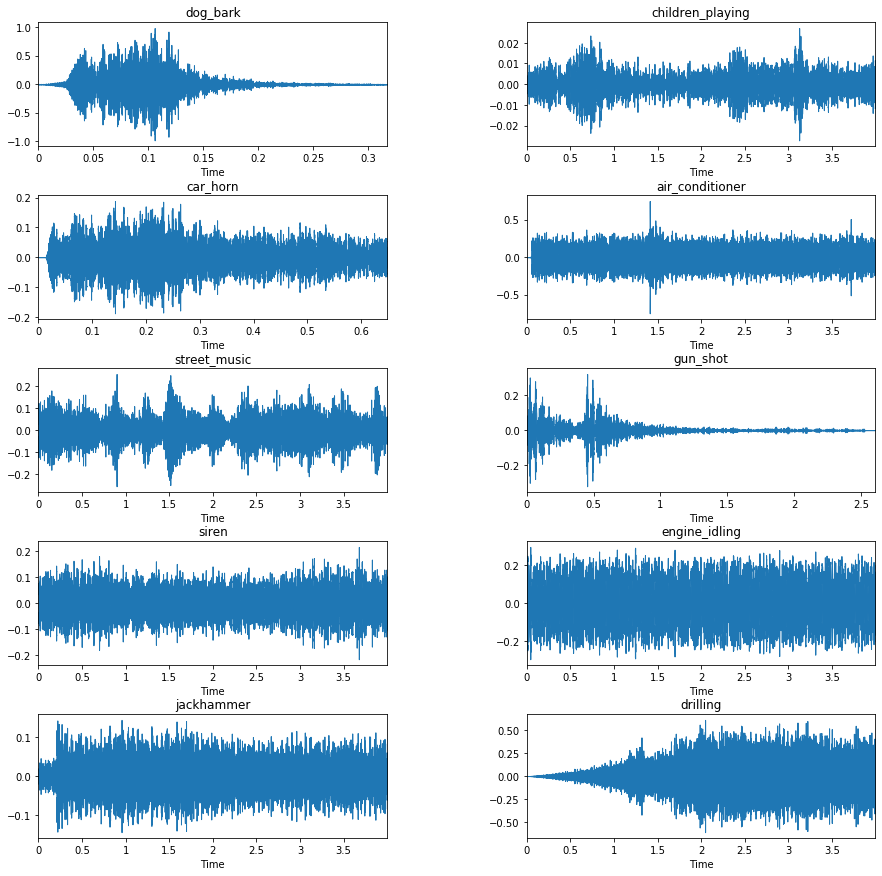

In [16]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn)
    _ = librosa.display.waveplot(data, sr= sample_rate)
plt.savefig('class_examples.png')

In [17]:
# Log graphic of waveforms to Comet
experiment.log_image('class_examples.png')

{'web': 'https://www.comet.ml/api/image/download?imageId=d629ed2112194f1fa5fa8d9efedc6d41&experimentKey=4f5d4c7d6c7d4976b04701bb33c20cca',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=d629ed2112194f1fa5fa8d9efedc6d41&experimentKey=4f5d4c7d6c7d4976b04701bb33c20cca'}

In [18]:
# Log audio files to Comet for debugging
for label in labels:
    fn = files[label]
    experiment.log_audio(fn, metadata = {'name': label})

Let's go through the audio samples and extract: number of audio channels, sample rate and bit-depth.

In [19]:
from wavfilehelper import WavFileHelper
wavfilehelper = WavFileHelper()

In [20]:
audiodata = []
for index, row in df.iterrows():
    fn = 'UrbanSound8K/audio/fold{}/{}'.format(row['fold'], row['slice_file_name'])
    data = wavfilehelper.read_file_properties(fn)
    audiodata.append(data)

In [21]:
# Convert to dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels', 'sample_rate', 'bit_depth'])

In [22]:
audiodf.head()

,num_channels,sample_rate,bit_depth
0,2,44100,16
1,2,44100,16
2,2,44100,16
3,2,44100,16
4,2,44100,16


In [23]:
print(audiodf.num_channels.value_counts(normalize=True))

2    0.915369
1    0.084631
Name: num_channels, dtype: float64


In [24]:
print(audiodf.sample_rate.value_counts(normalize=True))

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


In [25]:
print(audiodf.bit_depth.value_counts(normalize=True))

16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: bit_depth, dtype: float64


## Preprocessing

In [26]:
import librosa
from scipy.io import wavfile as wav

Librosa will automatically convert the sampling rate to 22.05 KHz.

In [27]:
fn = 'UrbanSound8K/audio/fold1/191431-9-0-66.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)

print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 48000
Librosa sample rate: 22050


Librosa's .load function will also normalize the bit-depth between -1 and 1. 

In [28]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -1869 to 1665
Librosa audio file min~max range: -0.05 to -0.05


Librosa also converts the audio signal to mono. 

{'web': 'https://www.comet.ml/api/image/download?imageId=3a8222683d974ade83ab676cd7c72bca&experimentKey=4f5d4c7d6c7d4976b04701bb33c20cca',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=3a8222683d974ade83ab676cd7c72bca&experimentKey=4f5d4c7d6c7d4976b04701bb33c20cca'}

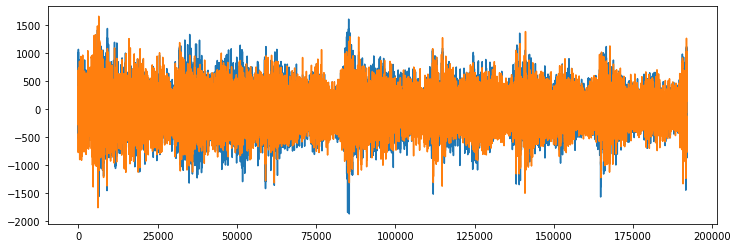

In [29]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')
experiment.log_image('original_audio.png')

{'web': 'https://www.comet.ml/api/image/download?imageId=d0b60e4f77bb49dea6c30c59eff217fe&experimentKey=4f5d4c7d6c7d4976b04701bb33c20cca',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=d0b60e4f77bb49dea6c30c59eff217fe&experimentKey=4f5d4c7d6c7d4976b04701bb33c20cca'}

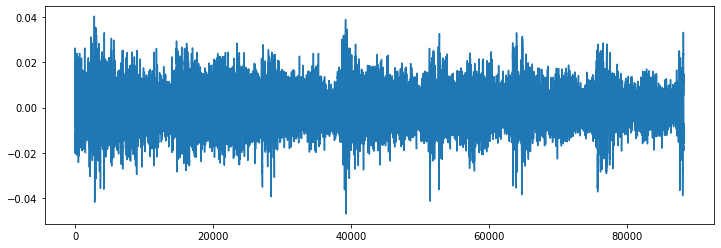

In [30]:
# Librosa: mono track
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')
experiment.log_image('librosa_audio.png')

## Extracting features

We will extract Mel-Frequency Cepstral Coefficients (MFCC) from the audio samples. 

The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

Extracting a MFCC
For this we will use Librosa's mfcc() function which generates an MFCC from time series audio data.

In [31]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)
print(mfccs.shape)

(40, 173)


Librosa calculated a series of 40 MFCCs over 173 frames

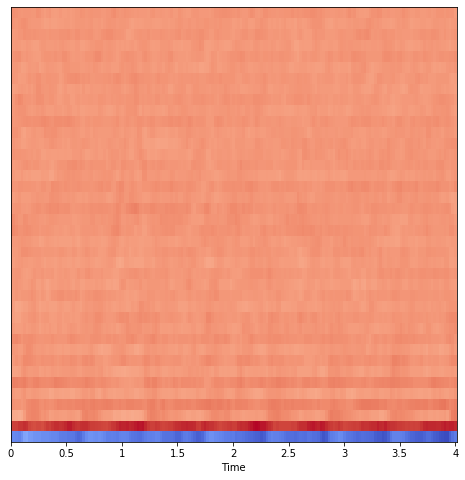

In [32]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')

In [33]:
experiment.log_image('MFCCs.png')

{'web': 'https://www.comet.ml/api/image/download?imageId=9b18d83eeee84c6da4161be8bfd20a67&experimentKey=4f5d4c7d6c7d4976b04701bb33c20cca',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=9b18d83eeee84c6da4161be8bfd20a67&experimentKey=4f5d4c7d6c7d4976b04701bb33c20cca'}

Extract MFCCs for every file

In [34]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [35]:
import os

In [36]:
# Set the path to the full UrbanSound dataset 
fulldatasetpath = 'UrbanSound8K/audio/'

metadata = df

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  8732  files


In [37]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [38]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [39]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [40]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [41]:
experiment.log_parameter('number_layers', len(model.layers))

In [42]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [43]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 1s 76us/step - loss: 9.4073 - accuracy: 0.1822 - val_loss: 2.1958 - val_accuracy: 0.2089
Epoch 2/100
6985/6985 [==============================] - 0s 57us/step - loss: 2.3106 - accuracy: 0.2252 - val_loss: 2.0956 - val_accuracy: 0.2519
Epoch 3/100
6985/6985 [==============================] - 0s 59us/step - loss: 2.0775 - accuracy: 0.2634 - val_loss: 1.9023 - val_accuracy: 0.3835
Epoch 4/100
6985/6985 [==============================] - 0s 58us/step - loss: 1.9260 - accuracy: 0.3121 - val_loss: 1.7215 - val_accuracy: 0.4150
Epoch 5/100
6985/6985 [==============================] - 0s 58us/step - loss: 1.8201 - accuracy: 0.3439 - val_loss: 1.6381 - val_accuracy: 0.4671
Epoch 6/100
6985/6985 [==============================] - 0s 58us/step - loss: 1.7042 - accuracy: 0.3887 - val_loss: 1.5014 - val_accuracy: 0.5249
Epoch 7/100
6985/6985 [==============================] - 0s 57us/step - loss

6985/6985 [==============================] - 0s 57us/step - loss: 0.6144 - accuracy: 0.7901 - val_loss: 0.4966 - val_accuracy: 0.8472
Epoch 57/100
6985/6985 [==============================] - 0s 58us/step - loss: 0.6110 - accuracy: 0.7987 - val_loss: 0.4992 - val_accuracy: 0.8495
Epoch 58/100
6985/6985 [==============================] - 0s 57us/step - loss: 0.5940 - accuracy: 0.8023 - val_loss: 0.4749 - val_accuracy: 0.8517
Epoch 59/100
6985/6985 [==============================] - 0s 59us/step - loss: 0.6102 - accuracy: 0.7911 - val_loss: 0.4788 - val_accuracy: 0.8626
Epoch 60/100
6985/6985 [==============================] - 0s 58us/step - loss: 0.5992 - accuracy: 0.7941 - val_loss: 0.4716 - val_accuracy: 0.8603
Epoch 61/100
6985/6985 [==============================] - 0s 59us/step - loss: 0.6018 - accuracy: 0.7986 - val_loss: 0.4729 - val_accuracy: 0.8632
Epoch 62/100
6985/6985 [==============================] - 0s 57us/step - loss: 0.5982 - accuracy: 0.7996 - val_loss: 0.4799 - val_a

# Testing

In [44]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9244094491004944
Testing Accuracy:  0.8797939419746399


In [45]:
def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

In [46]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [47]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [48]:
fn = 'UrbanSound8K/audio/fold9/103249-5-0-8.wav'
print("Ground truth class: {}".format(df[df['slice_file_name'] == '103249-5-0-8.wav']['class']))
print_prediction(fn)

Ground truth class: 235    engine_idling
Name: class, dtype: object
The predicted class is: engine_idling 

air_conditioner 		 :  0.00017181930888909846544265747070
car_horn 		 :  0.00000480797189084114506840705872
children_playing 		 :  0.02198834531009197235107421875000
dog_bark 		 :  0.00568095222115516662597656250000
drilling 		 :  0.00019264865841250866651535034180
engine_idling 		 :  0.96271759271621704101562500000000
gun_shot 		 :  0.00159105600323528051376342773438
jackhammer 		 :  0.00000968511176324682310223579407
siren 		 :  0.00153008766938000917434692382812
street_music 		 :  0.00611300626769661903381347656250


In [49]:
fn = 'UrbanSound8K/audio/fold5/111671-8-0-4.wav'
print("Ground truth class: {}".format(df[df['slice_file_name'] == '111671-8-0-4.wav']['class']))
print_prediction(fn)

Ground truth class: 667    siren
Name: class, dtype: object
The predicted class is: siren 

air_conditioner 		 :  0.00000000000000000000000000000000
car_horn 		 :  0.00000000000000000001589841622003
children_playing 		 :  0.00000000003671550563577596903997
dog_bark 		 :  0.00000132382172068901127204298973
drilling 		 :  0.00000000000000000000466811664266
engine_idling 		 :  0.00000000000000002355048220334616
gun_shot 		 :  0.00000000000006629075001603201844
jackhammer 		 :  0.00000000000000000000000000000000
siren 		 :  0.99999868869781494140625000000000
street_music 		 :  0.00000000000000000000000535889858


## Model Refinement

In [50]:
# Setting MFCCs to equal length to use a CNN

In [51]:
import numpy as np
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [53]:
features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  8732  files


In [54]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [55]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [56]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [57]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 41, 64)        

In [60]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 12
#num_batch_size = 128

num_epochs = 72
num_batch_size = 256

start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/72
6985/6985 [==============================] - 7s 1ms/step - loss: 1.5892 - accuracy: 0.4385 - val_loss: 1.6093 - val_accuracy: 0.4688
Epoch 2/72
6985/6985 [==============================] - 7s 1ms/step - loss: 1.4385 - accuracy: 0.5032 - val_loss: 1.4725 - val_accuracy: 0.5140
Epoch 3/72
6985/6985 [==============================] - 7s 1ms/step - loss: 1.3347 - accuracy: 0.5301 - val_loss: 1.3865 - val_accuracy: 0.5461
Epoch 4/72
6985/6985 [==============================] - 7s 1ms/step - loss: 1.2685 - accuracy: 0.5581 - val_loss: 1.3176 - val_accuracy: 0.5787
Epoch 5/72
6985/6985 [==============================] - 7s 1ms/step - loss: 1.1994 - accuracy: 0.5787 - val_loss: 1.2766 - val_accuracy: 0.5781
Epoch 6/72
6985/6985 [==============================] - 7s 1ms/step - loss: 1.1330 - accuracy: 0.6014 - val_loss: 1.1890 - val_accuracy: 0.6039
Epoch 7/72
6985/6985 [==============================] - 7s 1ms/step - loss: 1.0821 - acc

6985/6985 [==============================] - 7s 1ms/step - loss: 0.3037 - accuracy: 0.8942 - val_loss: 0.3614 - val_accuracy: 0.8781
Epoch 58/72
6985/6985 [==============================] - 7s 1ms/step - loss: 0.2884 - accuracy: 0.9008 - val_loss: 0.3839 - val_accuracy: 0.8809
Epoch 59/72
6985/6985 [==============================] - 7s 1ms/step - loss: 0.2924 - accuracy: 0.8976 - val_loss: 0.3985 - val_accuracy: 0.8752
Epoch 60/72
6985/6985 [==============================] - 7s 1ms/step - loss: 0.2854 - accuracy: 0.9015 - val_loss: 0.3648 - val_accuracy: 0.8832
Epoch 61/72
6985/6985 [==============================] - 7s 1ms/step - loss: 0.3052 - accuracy: 0.8972 - val_loss: 0.3709 - val_accuracy: 0.8849
Epoch 62/72
6985/6985 [==============================] - 7s 1ms/step - loss: 0.2910 - accuracy: 0.9009 - val_loss: 0.3784 - val_accuracy: 0.8735
Epoch 63/72
6985/6985 [==============================] - 7s 1ms/step - loss: 0.2864 - accuracy: 0.8985 - val_loss: 0.3746 - val_accuracy: 0.88

In [61]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9518969058990479
Testing Accuracy:  0.904979944229126


In [63]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [64]:
fn = 'UrbanSound8K/audio/fold9/103249-5-0-8.wav'
print("Ground truth class: {}".format(df[df['slice_file_name'] == '103249-5-0-8.wav']['class']))
print_prediction(fn)

Ground truth class: 235    engine_idling
Name: class, dtype: object
The predicted class is: engine_idling 

air_conditioner 		 :  0.00012409064220264554023742675781
car_horn 		 :  0.00000406973776989616453647613525
children_playing 		 :  0.00076734501635655760765075683594
dog_bark 		 :  0.00070466654142364859580993652344
drilling 		 :  0.00059925165260210633277893066406
engine_idling 		 :  0.99768710136413574218750000000000
gun_shot 		 :  0.00005663264164468273520469665527
jackhammer 		 :  0.00000685210261508473195135593414
siren 		 :  0.00004163502308074384927749633789
street_music 		 :  0.00000849456046125851571559906006
